# Modelisation

## Importation des librairies et datasets

In [41]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from catboost import CatBoostClassifier
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.selection import DropFeatures
from imblearn.over_sampling import RandomOverSampler

In [21]:
data_lg = pd.read_pickle("datasets/dataset.pkl")
data_sm = pd.read_pickle("datasets/dataset_withoutBadValues.pkl")

In [22]:
data = data_sm
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473218 entries, 0 to 899161
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Name           473218 non-null  object        
 1   City           473218 non-null  object        
 2   State          473218 non-null  category      
 3   Zip            473218 non-null  object        
 4   Bank           473218 non-null  object        
 5   BankState      473218 non-null  category      
 6   NAICS          473218 non-null  object        
 7   ApprovalDate   473218 non-null  datetime64[ns]
 8   ApprovalFY     473218 non-null  category      
 9   Term           473218 non-null  int64         
 10  NoEmp          473218 non-null  int64         
 11  NewExist       473218 non-null  category      
 12  CreateJob      473218 non-null  int64         
 13  RetainedJob    473218 non-null  int64         
 14  FranchiseCode  473218 non-null  object        
 15  Urban

## Création des sets

In [23]:
X = data.drop("MIS_Status", axis=1)
y = data.MIS_Status

In [24]:
cols_drop = ["Name", "City", "Zip", "NAICS", "ApprovalDate", "ApprovalFY", "CreateJob", "RetainedJob", "Franchised"]

X = X.drop(cols_drop, axis=1)

In [25]:
# Récupère le nom des colonnes par types
object_cols = list(X.select_dtypes(include=["object"]).columns)
cat_cols = list(X.select_dtypes(include=["category"]).columns)       #.drop(["ApprovalFY"])) à rajouter si utilisation de ApprovalFY
num_cols = list(X.select_dtypes(include=["int32", "int64"]).columns)

#year_col = ["ApprovalFY"]

# Ordinal encoding for ApprovalFY
# unique_years = sorted(data["ApprovalFY"].unique())

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.05, stratify=y, random_state=42)

### Oversampling de la classe 0 (création de train set oversampled)

In [27]:
data["MIS_Status"].value_counts(normalize=True)

MIS_Status
1    0.77799
0    0.22201
Name: proportion, dtype: float64

In [28]:
sample_strat = 0.65
oversample = RandomOverSampler(sampling_strategy=sample_strat)

X_oversample, y_oversample = oversample.fit_resample(X_train, y_train)

y_oversample.value_counts(normalize=True)

MIS_Status
1    0.606061
0    0.393939
Name: proportion, dtype: float64

## Preprocessing

### Column Transformer

In [29]:
preprocessing = ColumnTransformer([
        ("frequency", CountFrequencyEncoder(encoding_method="frequency", missing_values="ignore"), object_cols),
        ("scaler", StandardScaler(), num_cols),
        #("ordinal", OrdinalEncoder(categories=[unique_years], handle_unknown="use_encoded_value", unknown_value=-1), year_col),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

On ajoute des etapes dans le preprocessing pour les features de types objet et numeriques. Les features de types catégorielles seront gérées directement par catboost.

### Obtention des indices de colonnes post processing pour les features catégorielles

In [30]:
pre_fit = preprocessing.fit(X_train)
fit_cols = pre_fit.get_feature_names_out()

cat_indices = []
for i, col_name in enumerate(fit_cols):
    if col_name in cat_cols:
        cat_indices.append(i)

/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/variable_handling/_variable_type_checks.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return is_numeric(pd.to_numeric(column, errors="ignore"))
/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/variable_handling/_variable_type_checks.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return is_numeric(pd.to_numeric(column, errors="ignore"))


## Pipeline modèle catboost

In [31]:
catb = CatBoostClassifier(one_hot_max_size=70, verbose=0, cat_features=cat_indices, random_state=42)

pipeline_cb = make_pipeline(preprocessing, catb)

### Normal fit

In [13]:
pipeline_cb.fit(X_train, y_train)

/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/variable_handling/_variable_type_checks.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return is_numeric(pd.to_numeric(column, errors="ignore"))
/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/variable_handling/_variable_type_checks.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return is_numeric(pd.to_numeric(column, errors="ignore"))


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('frequency',
                                                  CountFrequencyEncoder(encoding_method='frequency',
                                                                        missing_values='ignore'),
                                                  ['Bank', 'FranchiseCode']),
                                                 ('scaler', StandardScaler(),
                                                  ['Term', 'NoEmp', 'GrAppv',
                                                   'SBA_Appv'])],
                                   verbose_feature_names_out=False)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7406e9c26320>)])

### Oversample fit

In [15]:
pipeline_cb_oversample = pipeline_cb
pipeline_cb_oversample.fit(X_oversample, y_oversample)

/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/variable_handling/_variable_type_checks.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return is_numeric(pd.to_numeric(column, errors="ignore"))
/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/variable_handling/_variable_type_checks.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return is_numeric(pd.to_numeric(column, errors="ignore"))


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('frequency',
                                                  CountFrequencyEncoder(encoding_method='frequency',
                                                                        missing_values='ignore'),
                                                  ['Bank', 'FranchiseCode']),
                                                 ('scaler', StandardScaler(),
                                                  ['Term', 'NoEmp', 'GrAppv',
                                                   'SBA_Appv'])],
                                   verbose_feature_names_out=False)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7406e9c26320>)])

## Métriques

### Normal fit

#### Classification report 

In [14]:
pred_test = pipeline_cb.predict(X_test)

print(classification_report(y_test, pred_test, digits=3))

              precision    recall  f1-score   support

           0      0.908     0.889     0.898      5253
           1      0.968     0.974     0.971     18408

    accuracy                          0.955     23661
   macro avg      0.938     0.931     0.935     23661
weighted avg      0.955     0.955     0.955     23661



/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) Bank, FranchiseCode.
  warnings.warn(


Le F1 macro pour notre modèle est de 0,935. Lorsque l'on regarde les scores de recall pour les deux classes, on se rend compte que le modèle à plus de probème à identifier la classe 0 (incapacité de rembourser) avec un recall de 0.889, que la classe 1 avec un recall de 0,974.

### Oversample fit

#### Classification report

In [16]:
pred_test_oversample = pipeline_cb_oversample.predict(X_test)

print(classification_report(y_test, pred_test_oversample, digits=3))

              precision    recall  f1-score   support

           0      0.864     0.930     0.896      5253
           1      0.980     0.958     0.969     18408

    accuracy                          0.952     23661
   macro avg      0.922     0.944     0.932     23661
weighted avg      0.954     0.952     0.953     23661



/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) Bank, FranchiseCode.
  warnings.warn(


Pour le modèle entrainé avec le train set oversampled, le F1 macro est à 0,932. En revanche on remarque que le modèle a des recalls plus équilibrés pour les deux classes (recall de 0.93 pour la classe 0 et 0.958 pour la classe 1), au détriment de la précision de la classe 0.

#### Confusion matrix

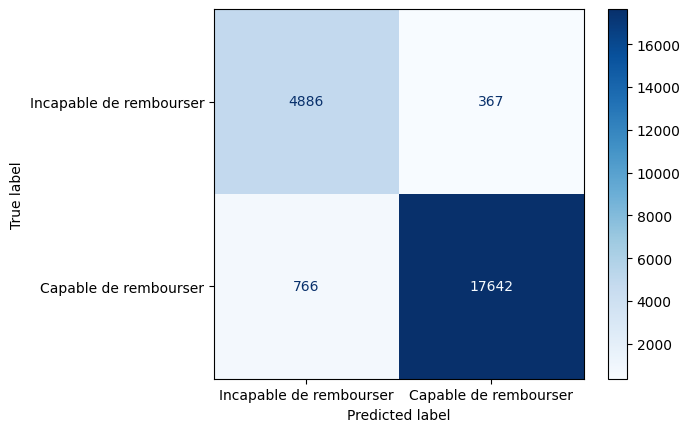

In [39]:
cm = confusion_matrix(y_test, pred_test_oversample)
graph_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Incapable de rembourser", "Capable de rembourser"])
graph_cm.plot(cmap="Blues")

## Features importance pour modèle oversample

In [17]:
print(pipeline_cb.steps)

[('columntransformer', ColumnTransformer(remainder='passthrough',
                  transformers=[('frequency',
                                 CountFrequencyEncoder(encoding_method='frequency',
                                                       missing_values='ignore'),
                                 ['Bank', 'FranchiseCode']),
                                ('scaler', StandardScaler(),
                                 ['Term', 'NoEmp', 'GrAppv', 'SBA_Appv'])],
                  verbose_feature_names_out=False)), ('catboostclassifier', <catboost.core.CatBoostClassifier object at 0x7406e9c26320>)]


In [18]:
# On extrait le noms des features et le modèle du pipeline
preprocessed_features = pipeline_cb_oversample.named_steps['columntransformer'].get_feature_names_out()
cb_model = pipeline_cb_oversample.named_steps['catboostclassifier']

feat_imp = pd.DataFrame({'features': preprocessed_features, 'score': cb_model.feature_importances_})
feat_imp.sort_values(by=['score'], ascending=False, inplace=True)
display(feat_imp)

,features,score
2,Term,57.428916
0,Bank,11.135566
7,BankState,10.587668
10,RevLineCr,3.796879
9,UrbanRural,3.550358
5,SBA_Appv,3.281257
6,State,2.464407
4,GrAppv,2.303428
13,NAICS2,1.725784
12,Zip2,1.192416


## Fine-tuning avec randomized search

In [37]:
catb_finetune = CatBoostClassifier(verbose=0, cat_features=cat_indices, random_state=42)

pipeline_finetune = make_pipeline(preprocessing, catb_finetune)

param_grid = {
    'catboostclassifier__iterations': np.random.randint(100, 1000, size=10),  
    'catboostclassifier__learning_rate': np.random.choice([0.01, 0.05, 0.1, 0.3, 0.5], size=10),
    'catboostclassifier__depth': np.random.randint(3, 10, size=10),
    'catboostclassifier__one_hot_max_size': np.random.randint(2, 100, size=10)
}

random_search = RandomizedSearchCV(pipeline_finetune, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
random_search.fit(X_oversample, y_oversample)

finetuned_model = random_search.best_estimator_
pred_finetuned = finetuned_model.predict(X_test)

print("Params optimaux")
display(random_search.best_params_)
print("")
print(classification_report(y_test, pred_finetuned, digits=3))

/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/variable_handling/_variable_type_checks.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return is_numeric(pd.to_numeric(column, errors="ignore"))
/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/variable_handling/_variable_type_checks.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return is_numeric(pd.to_numeric(column, errors="ignore"))
/home/utilisateur/Documents/Projets/briefs/loan_project/.venv/lib/python3.10/site-packages/feature_engine/encoding/base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) Bank, FranchiseCode.
  warnings.warn(

KeyboardInterrupt: 

## Exportation du model

In [18]:
with open("model/model_cb.pkl", "wb") as f:
  pickle.dump(pipeline_cb_oversample, f)
f.close()